In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [120]:
groundTruth_Users = os.listdir("groundTruth")
MyoData_Users = os.listdir("MyoData")

In [121]:
user_id = []
for i in range(len(MyoData_Users)):
    if MyoData_Users[i] in groundTruth_Users:
        user_id.append(MyoData_Users[i])
        
directory_clean_data = "clean_data/"
if not os.path.exists(directory_clean_data):
        os.makedirs(directory_clean_data)

In [137]:
def get_paths(user, fork_or_spoon= 'fork'):
    parent_path = "MyoData/" + user + '/' + fork_or_spoon
    dir_list = os.listdir(parent_path)
    EMG_txt_path = parent_path + "/" + dir_list[0]
    IMU_txt_path = parent_path + "/" + dir_list[1]
    video_info_path = parent_path + "/" + dir_list[2]
    # get ground truth
    ground_truth_parent_path = "groundTruth/" + user + '/' + fork_or_spoon
    ground_truth_dir_list = os.listdir(ground_truth_parent_path)
    ground_truth_path = ground_truth_parent_path + "/" + ground_truth_dir_list[0]
    return (EMG_txt_path, IMU_txt_path, video_info_path, ground_truth_path)

def mul(x, y):
    try:
        return np.round(pd.to_numeric(x) * y)
    except:
        return x

def get_dataframe(user = "user10", data_for="EMG", fork_or_spoon="fork"):
    paths = get_paths(user, fork_or_spoon)
    if data_for == "EMG":
        df = pd.read_csv(paths[0], sep=",", header=None)
        df.columns = ['UNIX time stamp', 'EMG 1', 'EMG 2', 'EMG 3', 'EMG 4', 'EMG 5', 'EMG 6', 'EMG 7', 'EMG 8']
        return df.assign(eating=False)
    elif( data_for == "IMU"):
        df = pd.read_csv(paths[1], sep=",", header=None)
        df.columns = ['UNIX time stamp', 'Orientation X', 'Orientation Y', 'Orientation Z', 'Orientation W', 'Accelerometer X', 'Accelerometer Y', 'Accelerometer Z', 'Gyroscope X', 'Gyroscope Y','Gyroscope Z'] 
        return df.assign(eating=False)
    elif( data_for == "ground_truth"):
        df = pd.read_csv(paths[3], sep=",", header=None)
        df.columns = ["start","stop", "noise"] 
        df.drop(['noise'],axis=1,inplace=True)
        return df.applymap(lambda x: mul(x, 100/30))
    else:
        df = pd.read_csv(paths[2], header=None)
        df.columns = ["starting frame", "ending frame"]
        return df
    
def save_clean_data(df_ground_truth, df, name, user, fork_or_spoon="fork"):
    for index, row in df_ground_truth.iterrows():
        eating_start = row[0] # note: maybe add one here. depends on if index at 0 or 1. I assumed 0
        eating_stop = row[1]
        df.loc[ eating_start:eating_stop , 'eating'] = True
    

    df_eating = df[df['eating'] == True]
    df_not_eating = df[df['eating'] == False]
    
    directory = "clean_data/" + user + "/" + fork_or_spoon
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    #df_eating.to_csv(sep=',', index=False, header=False)
    df_eating.reset_index(drop=True,inplace=True)
    df_not_eating.reset_index(drop=True,inplace=True)
    min_data_points = min(df_eating.shape[0], df_not_eating.shape[0])
    df_eating = df_eating.iloc[:min_data_points]
    df_not_eating = df_not_eating.iloc[:min_data_points]
    
    df_eating.to_csv(path_or_buf=directory+"/eating_" + name + ".txt", sep=',')
    df_not_eating.to_csv(path_or_buf=directory+"/not_eating_" + name + ".txt", sep=',')
    df.to_csv(path_or_buf=directory+"/master_df" + name + ".txt", sep=',')
    

In [138]:
def clean_data_for_each_user():
    
    for user in user_id:
        for fork_or_spoon in ['spoon','fork']:
            try:
                df_EMG = get_dataframe(user, data_for="EMG", fork_or_spoon=fork_or_spoon)
                df_IMU = get_dataframe(user, data_for="IMU", fork_or_spoon=fork_or_spoon)
                df_ground_truth = get_dataframe(user, data_for="ground_truth", fork_or_spoon=fork_or_spoon)

                save_clean_data(df_ground_truth, df_EMG, name="EMG", user=user, fork_or_spoon=fork_or_spoon)
                save_clean_data(df_ground_truth, df_IMU, name="IMU", user=user, fork_or_spoon=fork_or_spoon)
            except:
                print("folder name for users don't match or error in csv for ---> " + user)
                print("removing from list of users to use in the project")
                user_id.remove(user)

In [139]:
def get_clean_paths(user, fork_or_spoon= 'fork'):
    parent_path = "clean_data/" + user + '/' + fork_or_spoon
    #dir_list = os.listdir(parent_path)
    EMG_eating_txt_path = parent_path + "/" + "eating_EMG.txt"
    EMG_not_eating_txt_path = parent_path + "/" + "not_eating_EMG.txt"
    IMU_eating_txt_path = parent_path + "/" + "eating_IMU.txt"
    IMU_not_eating_txt_path = parent_path + "/" + "not_eating_IMU.txt"
    master_EMG_path = parent_path + "/" + "master_dfEMG.txt"
    master_IMU_path = parent_path + "/" + "master_dfIMU.txt"
    return (master_EMG_path, EMG_eating_txt_path, EMG_not_eating_txt_path, master_IMU_path, IMU_eating_txt_path, IMU_not_eating_txt_path)

def get_clean_df(user = "user10", data_for="EMG", fork_or_spoon="fork", eating=True, master=False):
    paths = get_clean_paths(user, fork_or_spoon)
    if data_for == "EMG":
        if master:
            return pd.read_csv(paths[0], sep=",", index_col=0)
        elif eating:
            return pd.read_csv(paths[1], sep=",", index_col=0)
        else:
            return pd.read_csv(paths[2], sep=",", index_col=0)

    elif( data_for == "IMU"):
        if master:
            return pd.read_csv(paths[3], sep=",", index_col=0)
        elif eating:
            return pd.read_csv(paths[4], sep=",", index_col=0)
        else:
            return pd.read_csv(paths[5], sep=",", index_col=0)
    

# RMS

In [187]:
# RMS_feature_extraction(df1,df2)
# RMS_feature_extraction(df1_IMU,df2_IMU)
def RMS_feature_extraction(df1,df2,col_wise=True,user="user10", get_feature_data=False):
    if col_wise:
        axis = 0
        n = (df1.iloc[:,1:-1]).shape[0]
    else:
        axis = 1 
        n = (df1.iloc[:,1:-1]).shape[1]
    if get_feature_data:
        eating_feature_data = ((((df1.iloc[:,1:-1]**2).sum(axis))/n).pow(1/2))
        non_eating_feature_data = (((df2.iloc[:,1:-1]**2).sum(axis)/n).pow(1/2))
        return ( (pd.DataFrame(eating_feature_data)).T, (pd.DataFrame(non_eating_feature_data)).T )
    
    try:
        ax = ((((df1.iloc[:,1:-1]**2).sum(axis))/n).pow(1/2)).plot(label='eating',legend=True)
        ((df2.iloc[:,1:-1]**2).sum(axis)/n).pow(1/2).plot(ax=ax,label='not eating',legend=True, title=user)
        plt.xticks(rotation=70)
        plt.title("RMS for " + user )
        plt.savefig('graphs/RMS' + user +'.png' , bbox_inches='tight')
        plt.show()
    except:
        print("error in RMS_feature_extraction()")

# avg

In [188]:
# AVG_feature_extraction(df1,df2)
# AVG_feature_extraction(df1_IMU,df2_IMU)
def AVG_feature_extraction(df1,df2,col_wise=True,user="user10", get_feature_data=False):
    if col_wise:
        axis = 0
    else:
        axis = 1 
    if get_feature_data:
        eating_feature_data = ((df1.iloc[:,1:-1]).abs().mean(axis))
        non_eating_feature_data = ((df2.iloc[:,1:-1]).abs().mean(axis))
        return ( (pd.DataFrame(eating_feature_data)).T, (pd.DataFrame(non_eating_feature_data)).T )
    
    try:
        ax = ((df1.iloc[:,1:-1]).abs().mean(axis)).plot(label='eating',legend=True)
        ((df2.iloc[:,1:-1]).abs().mean(axis)).plot(ax=ax,label='not eating',legend=True, title=user)
        plt.xticks(rotation=70)
        plt.title("AVG for " + user )
        plt.savefig('graphs/AVG' + user +'.png' , bbox_inches='tight')
        plt.show()
    except:
        print("error in AVG_feature_extraction()")

# min

In [189]:
# MIN_feature_extraction(df1,df2)
def MIN_feature_extraction(df1,df2,col_wise=True,user="user10", get_feature_data=False):
    if col_wise:
        axis = 0
    else:
        axis = 1 
    if get_feature_data:
        eating_feature_data = ((df1.iloc[:,1:-1]).min(axis))
        non_eating_feature_data = ((df2.iloc[:,1:-1]).min(axis))
        return ( (pd.DataFrame(eating_feature_data)).T, (pd.DataFrame(non_eating_feature_data)).T )
    
    try:
        ax = ((df1.iloc[:,1:-1]).min(axis)).plot(label='eating',legend=True)
        ((df2.iloc[:,1:-1]).min(axis)).plot(ax=ax,label='not eating',legend=True, title=user)
        plt.xticks(rotation=70)
        plt.title("MIN for " + user )
        plt.savefig('graphs/MIN' + user +'.png' , bbox_inches='tight')
        plt.show()
    except:
        print("error in MIN_feature_extraction()")

# max

In [190]:
# MAX_feature_extraction(df1,df2)
# MAX_feature_extraction(df1_IMU,df2_IMU)
def MAX_feature_extraction(df1,df2,col_wise=True,user="user10", get_feature_data=False):
    if col_wise:
        axis = 0
    else:
        axis = 1 
        
    if get_feature_data:
        eating_feature_data = ((df1.iloc[:,1:-1]).abs().max(axis))
        non_eating_feature_data = ((df2.iloc[:,1:-1]).abs().max(axis))
        return ( (pd.DataFrame(eating_feature_data)).T, (pd.DataFrame(non_eating_feature_data)).T )
    
    try:
        ax = ((df1.iloc[:,1:-1]).abs().max(axis)).plot(label='eating',legend=True)
        ((df2.iloc[:,1:-1]).abs().max(axis)).plot(ax=ax,label='not eating',legend=True, title=user)
        plt.xticks(rotation=70)
        plt.title("MAX for " + user )
        plt.savefig('graphs/MAX' + user +'.png' , bbox_inches='tight')
        plt.show()
    except:
        print("error in MAX_feature_extraction()")

# std

In [191]:
# STD_feature_extraction(df1,df2)
# STD_feature_extraction(df1_IMU,df2_IMU)
def STD_feature_extraction(df1,df2,col_wise=True,user="user10", get_feature_data=False):
    if col_wise:
        axis = 0
    else:
        axis = 1 
        
    if get_feature_data:
        eating_feature_data = ((df1.iloc[:,1:-1]).std(axis))
        non_eating_feature_data = ((df2.iloc[:,1:-1]).std(axis))
        return ( (pd.DataFrame(eating_feature_data)).T, (pd.DataFrame(non_eating_feature_data)).T )
    
    try:
        ax = ((df1.iloc[:,1:-1]).abs().std(axis)).plot(label='eating',legend=True)
        ((df2.iloc[:,1:-1]).abs().std(axis)).plot(ax=ax,label='not eating',legend=True, title=user)
        plt.xticks(rotation=70)
        plt.title("STD for " + user )
        plt.savefig('graphs/STD' + user +'.png' , bbox_inches='tight')
        plt.show()
        
    except:
        print("error in STD_feature_extraction()")

# Phase One: Data Cleaning and Organization

In [136]:
# code to clean all of the data this can take a moment
clean_data_for_each_user()

# Phase Two: Feature Extraction

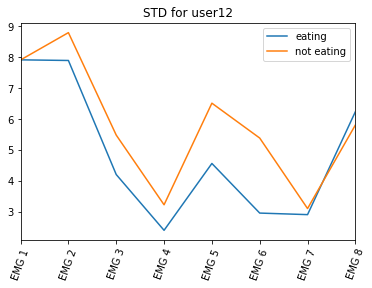

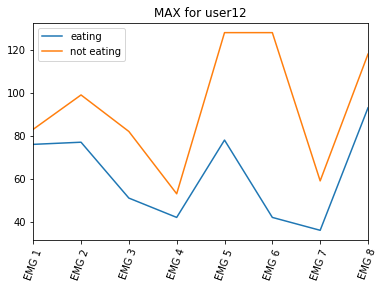

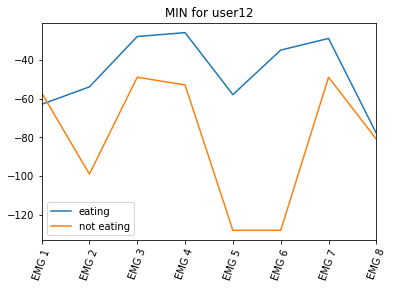

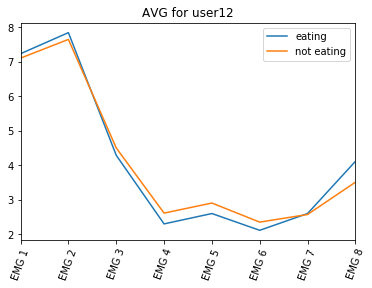

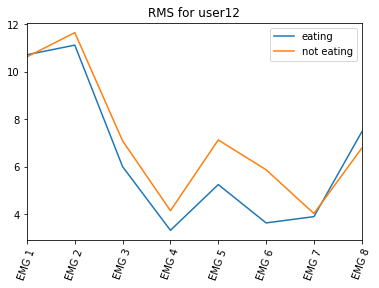

In [196]:
user_id = os.listdir("clean_data")
user_id.remove('.ipynb_checkpoints')

directory_graphs = "graphs/"
if not os.path.exists(directory_graphs):
        os.makedirs(directory_graphs)

feature_user = 'user12'
df1 = get_clean_df(user=feature_user, fork_or_spoon=item, eating=True)
df2 = get_clean_df(user=feature_user, fork_or_spoon=item, eating=False)

STD_feature_extraction(df1,df2,col_wise=True,user=feature_user)
MAX_feature_extraction(df1,df2,col_wise=True,user=feature_user)
MIN_feature_extraction(df1,df2,col_wise=True,user=feature_user)
AVG_feature_extraction(df1,df2,col_wise=True,user=feature_user)
RMS_feature_extraction(df1,df2,col_wise=True,user=feature_user)


# Phase Three: Feature Selection

## Subtask 1: Arranging the feature matrix

In [20]:
feature_df = pd.DataFrame()

for user in user_id:
    for item in ['fork','spoon']:

        df1 = get_clean_df(user=user, fork_or_spoon=item, eating=True)
        df2 = get_clean_df(user=user, fork_or_spoon=item, eating=False)
        #df1_IMU = get_clean_df(data_for="IMU",eating=True,user=user)
        #df2_IMU = get_clean_df(data_for="IMU",eating=False,user=user)

        (STD_eating_EMG, STD_non_eating_EMG) = STD_feature_extraction(df1,df2,col_wise=True,user=user,get_feature_data=True)
        (MAX_eating_EMG, MAX_non_eating_EMG) = MAX_feature_extraction(df1,df2,col_wise=True,user=user,get_feature_data=True)
        (MIN_eating_EMG, MIN_non_eating_EMG) = MIN_feature_extraction(df1,df2,col_wise=True,user=user,get_feature_data=True)
        (AVG_eating_EMG, AVG_non_eating_EMG) = AVG_feature_extraction(df1,df2,col_wise=True,user=user,get_feature_data=True)
        (RMS_eating_EMG, RMS_non_eating_EMG) = RMS_feature_extraction(df1,df2,col_wise=True,user=user,get_feature_data=True)

        STD_eating_EMG.columns = [str(col) + ' ' + 'STD' for col in STD_eating_EMG.columns]
        MAX_eating_EMG.columns = [str(col) + ' ' + 'MAX' for col in MAX_eating_EMG.columns]
        MIN_eating_EMG.columns = [str(col) + ' ' + 'MIN' for col in MIN_eating_EMG.columns]
        AVG_eating_EMG.columns = [str(col) + ' ' + 'AVG' for col in AVG_eating_EMG.columns]
        RMS_eating_EMG.columns = [str(col) + ' ' + 'RMS' for col in RMS_eating_EMG.columns]

        STD_non_eating_EMG.columns = [str(col) + ' ' + 'STD' for col in STD_non_eating_EMG.columns]
        MAX_non_eating_EMG.columns = [str(col) + ' ' + 'MAX' for col in MAX_non_eating_EMG.columns]
        MIN_non_eating_EMG.columns = [str(col) + ' ' + 'MIN' for col in MIN_non_eating_EMG.columns]
        AVG_non_eating_EMG.columns = [str(col) + ' ' + 'AVG' for col in AVG_non_eating_EMG.columns]
        RMS_non_eating_EMG.columns = [str(col) + ' ' + 'RMS' for col in RMS_non_eating_EMG.columns]

        #feature_df = STD_eating_EMG.append(MAX_eating_EMG)

        # feature_df = (STD_eating_EMG
        #     .append(MAX_eating_EMG)
        #     .append(MIN_eating_EMG)
        #     .append( AVG_eating_EMG)
        #     .append(RMS_eating_EMG)
        #     )
        eating_row = (STD_eating_EMG
                      .join(MAX_eating_EMG)
                      .join(MIN_eating_EMG)
                      .join(AVG_eating_EMG)
                      .join(RMS_eating_EMG)
                     )
        eating_row['eating'] = True
        feature_df = feature_df.append(eating_row,ignore_index=True)

        non_eating_row = (STD_non_eating_EMG
                      .join(MAX_non_eating_EMG)
                      .join(MIN_non_eating_EMG)
                      .join(AVG_non_eating_EMG)
                      .join(RMS_non_eating_EMG)
                     )
        non_eating_row['eating'] = False
        feature_df = feature_df.append(non_eating_row,ignore_index=True)
    
    

In [95]:
feature_df.head()
#backup_feature_df = feature_df
#backup_feature_df.head()

,EMG 1 STD,EMG 2 STD,EMG 3 STD,EMG 4 STD,EMG 5 STD,EMG 6 STD,EMG 7 STD,EMG 8 STD,EMG 1 MAX,EMG 2 MAX,...,EMG 8 AVG,EMG 1 RMS,EMG 2 RMS,EMG 3 RMS,EMG 4 RMS,EMG 5 RMS,EMG 6 RMS,EMG 7 RMS,EMG 8 RMS,eating
0,7.241242,6.592087,5.126500,3.274318,3.755429,3.125149,4.132490,6.594337,55,38,...,4.241098,7.278428,6.645336,5.198460,3.365987,3.843083,3.223154,4.206555,6.645819,True
1,5.599068,6.751682,4.743793,3.575945,4.829304,3.230622,3.846011,7.245190,76,90,...,3.626607,5.640635,6.802026,4.822902,3.665306,4.894763,3.322175,3.917706,7.291955,False
2,6.504815,4.498429,3.932417,2.769719,3.502519,2.834979,3.708052,5.181027,50,37,...,3.207001,6.541654,4.569520,4.017523,2.874545,3.596154,2.937585,3.793934,5.239291,True
3,6.024292,4.667400,3.911983,3.401979,5.096712,3.946818,4.215570,5.012612,76,62,...,2.936523,6.065088,4.739048,4.001225,3.491948,5.157089,4.021877,4.293356,5.073900,False
4,7.731259,6.955888,5.313281,5.057383,5.838771,4.403287,3.259664,13.285301,69,53,...,8.679775,7.762455,7.005060,5.381479,5.116919,5.889923,4.467027,3.344728,13.303910,True


## Subtask 2: Execution of PCA

Top 5 eigenvalues:
[17.47074122  4.99964568  4.26169466  2.72843845  2.40927456]


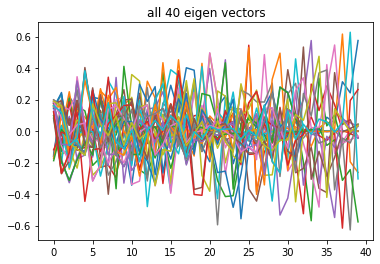

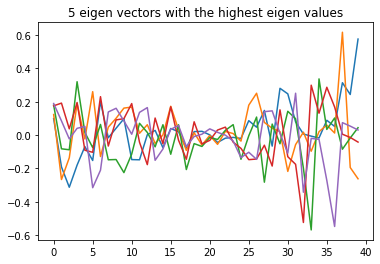

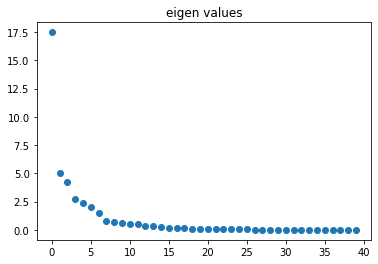

In [197]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


X = feature_df.iloc[:,:-1]
X_std = StandardScaler().fit_transform(feature_df.iloc[:,:-1])

#pca = PCA(n_components=2)
pca = PCA()
Y = pca.fit_transform(X_std)

#cov_mat = np.cov(X_std.T)
#eigen_values, eigen_vectors = np.linalg.eig(cov_mat)
eigen_values = pca.explained_variance_
eigen_vectors = pca.components_

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

    
print("Top 5 eigenvalues:")
print(eigen_values[0:5])
plt.plot(eigen_vectors)
plt.title("all 40 eigen vectors")
plt.show()
plt.plot(eig_pairs[0][1])
plt.plot(eig_pairs[1][1])
plt.plot(eig_pairs[2][1])
plt.plot(eig_pairs[3][1])
plt.plot(eig_pairs[4][1])
plt.title("5 eigen vectors with the highest eigen values")
plt.savefig('graphs/eigenVectors' + user +'.png' , bbox_inches='tight')
plt.show()
plt.scatter(range(len(eigen_values)),eigen_values)
plt.title("eigen values")
plt.savefig('graphs/eigenValues' + user +'.png' , bbox_inches='tight')
plt.show()

# Subtask 3: Make sense of the PCA eigen vectors 

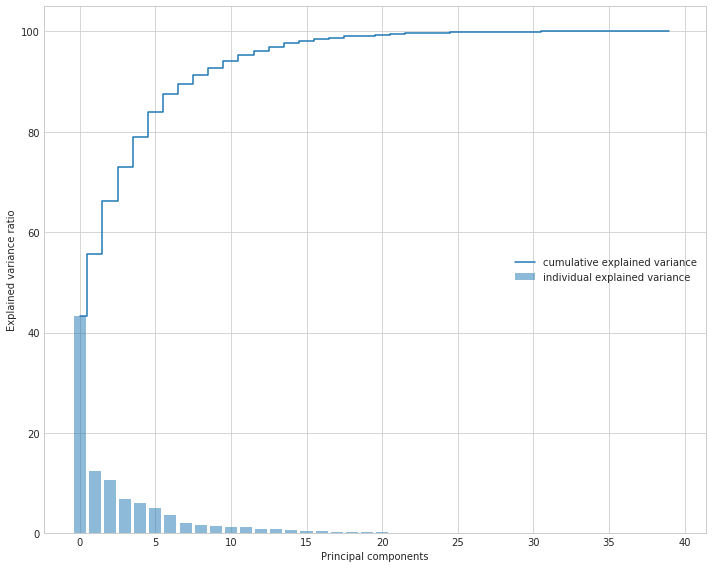

In [199]:
tot = sum(eigen_values)
var_exp = [(i / tot)*100 for i in sorted(eigen_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10, 8))

    plt.bar(range(40), var_exp, alpha=0.5, align='center',label='individual explained variance')
    plt.step(range(40), cum_var_exp, where='mid',label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='center right')
    plt.tight_layout()
    plt.savefig('graphs/explained_variance' + user +'.png' , bbox_inches='tight')
    plt.show()

In [117]:
# here we can take the first principle component or the eigenvector with the highest eigenvalue and we can sort the weights and 
# use a background_gradient to see which sensors have the greatest weights. This lets us know which sensors are more important than others.
# when we make the projection matrix and multiply by the original feature space, the small weights mean that the sensor value will have little effect
# on the resulting projection matrix or new feature space.
sorted_eigen_vectors = []
for eigen_tuple in eig_pairs:
    sorted_eigen_vectors.append(eigen_tuple[1])

eigen_vectors_df = pd.DataFrame(sorted_eigen_vectors)
eigen_vectors_df.columns = (feature_df.iloc[:,:-1]).columns
first = eigen_vectors_df.iloc[0].sort_values(ascending=False)
pd.DataFrame(first).style.background_gradient()

,0
EMG 8 RMS,0.575302
EMG 6 RMS,0.31355
EMG 6 AVG,0.280126
EMG 7 AVG,0.246905
EMG 7 RMS,0.243111
EMG 7 STD,0.201118
EMG 4 AVG,0.147392
EMG 1 STD,0.0980468
EMG 2 MAX,0.0977235
EMG 4 RMS,0.0882647


In [118]:
# here I listed just the first five principle components and used the background gradient to help show that darker colors
# correspond to heavy or more important weights, and lighter colors are less important wieghts. 
first = eigen_vectors_df.iloc[:5]#.sort_values(ascending=False)
pd.DataFrame(first).style.background_gradient()

,EMG 1 STD,EMG 2 STD,EMG 3 STD,EMG 4 STD,EMG 5 STD,EMG 6 STD,EMG 7 STD,EMG 8 STD,EMG 1 MAX,EMG 2 MAX,EMG 3 MAX,EMG 4 MAX,EMG 5 MAX,EMG 6 MAX,EMG 7 MAX,EMG 8 MAX,EMG 1 MIN,EMG 2 MIN,EMG 3 MIN,EMG 4 MIN,EMG 5 MIN,EMG 6 MIN,EMG 7 MIN,EMG 8 MIN,EMG 1 AVG,EMG 2 AVG,EMG 3 AVG,EMG 4 AVG,EMG 5 AVG,EMG 6 AVG,EMG 7 AVG,EMG 8 AVG,EMG 1 RMS,EMG 2 RMS,EMG 3 RMS,EMG 4 RMS,EMG 5 RMS,EMG 6 RMS,EMG 7 RMS,EMG 8 RMS
0,0.0980468,-0.191349,-0.313032,-0.180572,-0.0693875,-0.152699,0.201118,-0.0164361,0.0409024,0.0977235,-0.147321,-0.148484,0.00178039,0.0277891,-0.0756945,0.039112,0.0201785,-0.0799678,0.0203425,0.0222644,0.00103866,-0.0445312,-0.0188482,-0.0141576,-0.0203244,0.086093,0.0470498,0.147392,-0.0664086,0.280126,0.246905,0.0788351,0.00602225,-0.00667148,-0.017761,0.0882647,0.051664,0.31355,0.243111,0.575302
1,0.122887,-0.266736,-0.136511,0.188497,-0.0234923,0.259962,-0.128897,0.0473059,0.100644,0.161482,0.167542,0.0104207,0.0618308,-0.0504556,0.000588541,0.172417,0.0317174,-0.092248,0.0133998,-0.0602792,-0.00223286,-0.0558936,0.0217609,0.00885795,-0.0364051,0.178973,0.250574,0.0755397,0.0405457,0.0205141,-0.218102,-0.0573452,0.0170445,-0.0970166,0.0200577,0.0594835,0.0120766,0.616293,-0.194748,-0.262305
2,0.178999,-0.0825961,-0.0883128,0.319759,0.0150438,-0.0751531,0.0634185,-0.148406,-0.146885,-0.225304,-0.11414,0.0702416,0.0154759,-0.0707911,0.0617903,-0.115196,0.0614682,-0.206932,-0.0514591,-0.0684537,-0.0145607,-0.0265986,0.0281322,0.0622398,-0.145375,-0.00464849,0.107743,-0.282784,0.0655764,-0.0523269,0.142381,0.0975899,-0.198601,-0.56893,0.336593,0.0336348,0.102127,-0.0849874,-0.0179174,0.0439067
3,0.175132,0.191355,0.0372477,0.195009,-0.0911063,-0.103498,0.23,-0.0659253,0.09075,0.0981654,0.188577,-0.0432414,-0.17745,0.101905,-0.0525708,0.169224,-0.0310206,-0.145263,0.079357,-0.0528777,-0.0320533,0.0298769,0.0473079,-0.0427266,-0.0800161,-0.147675,-0.143891,-0.0610811,-0.185985,0.150972,-0.12997,-0.175624,-0.524296,0.298766,0.130764,0.286459,0.168007,0.00489632,-0.0145167,-0.0422862
4,0.188982,0.0847042,-0.0231709,0.0402107,0.0513666,-0.315848,-0.21085,0.138321,0.160457,0.0848493,0.00483789,0.135888,0.164473,-0.151531,-0.0837719,0.0344259,0.0566962,-0.0688098,-0.0088406,0.0050668,0.0370484,0.016122,-0.000686569,-0.0354816,-0.135734,-0.103225,-0.145918,0.140028,0.145044,0.00972024,-0.108456,0.25062,-0.342961,-0.0200688,-0.0260591,-0.272223,-0.548267,0.0742488,0.0534435,0.0302169


# Subtask 4: Results of PCA

In [99]:
# the new feature matrix is made by performing the dot product between the projection matrix W 
# ( which is the matrix containing the top k eigenvectors with the hightest eigenvalues)
# We are going to use the top 5 eigenvectors (or principle components) because with 5 you can see
# about 80% of the data
# so we take the projection matrix, and we take the dot product with the original feature matrix to obtain the new feature matrix or new feature space
# sklearn has a built in PCA function which will perform this operation for us

pca_5 = PCA(n_components=5)
Y_5 = pca_5.fit_transform(X_std)
pd.DataFrame(Y_5)

,0,1,2,3,4
0,-4.401785,1.705036,-0.714792,0.543212,-0.804296
1,-2.087834,0.582423,1.913580,-0.652530,1.030841
2,-5.460488,1.952316,0.726587,-0.785450,-0.286094
3,-2.363377,1.141249,2.747649,-2.425917,-1.117640
4,-1.817123,2.849611,-0.939372,1.083352,1.646247
...,...,...,...,...,...
107,2.187063,-0.888084,3.743214,2.928188,-0.084006
108,-3.205770,0.396926,-1.181326,1.426875,1.452101
109,0.574565,-1.146661,4.066903,0.667808,2.466294
110,-1.509273,0.246322,-1.186209,0.365074,3.577279


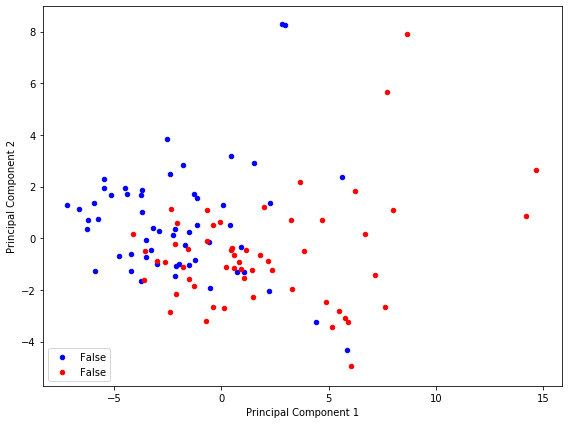

In [200]:
# To help understand the new feature matrix. We can look at the projection of data points onto PC 1, 2, and 3
# These plots below help show how the variance in the data is greastest for PC 1, then 2, then 3 etc
# these plots will be explained in the paper
class_label = feature_df.iloc[:,-1]
plt.figure(figsize=(8, 6))
for value, color in zip((True,False),
                    ('blue','red')):
    plt.scatter(Y[class_label == value, 0],
                Y[class_label == value, 1],
                label = lab,
                c = color,
                s = 20)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig('graphs/2D.png' , bbox_inches='tight')
plt.show()

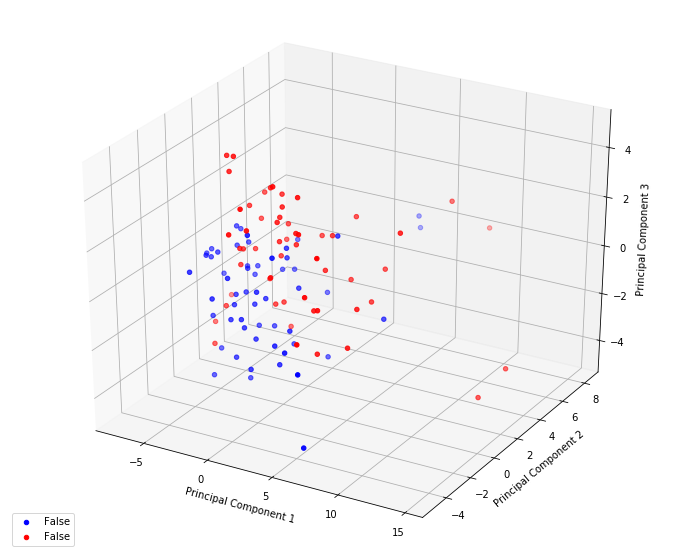

In [201]:
from mpl_toolkits.mplot3d import Axes3D
#sklearn_pca = sklearnPCA(n_components=3)
#Y_sklearn = sklearn_pca.fit_transform(X_std)

fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(111, projection='3d')

for value, color in zip((True,False),
                        ('blue','red')):
        ax.scatter(Y[class_label == value, 0],
                   Y[class_label == value, 1],
                   Y[class_label == value, 2],
                   label = lab,
                   c = color)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.legend(loc='lower left')
plt.savefig('graphs/3D.png' , bbox_inches='tight')
plt.show()

# Subtask 5: Argue whether doing PCA was helpful or not

In [ ]:
# this will be discussed in the paper